In [1]:
# %load subject_class.py
from __future__ import print_function, division
import re
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

class subject(object):
    """try to organize data based on subject ex sub001"""
    def __init__(self,sub):
        # subject info ex: 'sub001'
        self.sub_id = sub

        # BOLD folder for this subject
        sub_BOLD_path = "../data/ds105/%s/BOLD/" %self.sub_id

        # anatomy folder for this subject
        sub_anatomy_file = "../data/ds105/%s/anatomy/highres001_brain.nii.gz" %self.sub_id
        
        # runfile_list: ['task001_run001', 'task001_run002'......]
        runfile_list = ['task001_run'+ i+ '.txt' for i in ['001','002','003','004','005','006','007','008','009','010','011','012']]
        runlist = ['run'+ i for i in ['001','002','003','004','005','006','007','008','009','010','011','012']]
        if self.sub_id == "sub005":
            runfile_list = runfile_list[:-1]
            runlist = runlist[:-1]

        # TR info:
        self.TR = 2.5
        
        # load high resolution brain structure for this subject
        self.brain_img = nib.load(sub_anatomy_file)
        
        # load all bold image file for this subject
        self.run_img_result = {}
        for i in runlist:
            self.run_img_result[self.sub_id + '_' + i] = nib.load(sub_BOLD_path+'task001_'+i+'/bold.nii.gz')
        
        # all run keys:
        self.run_keys = self.run_img_result.keys()

        # shape of the BOLD data:
        self.BOLD_shape = self.run_img_result[self.run_keys[1]].shape
        
        # conditions setting: which condition is for which category
        self.condition_key_file = open("../data/ds105/models/model001/condition_key.txt")
        condition_list = self.condition_key_file.readlines()
        condition = re.compile(r'(cond\d+) (\w+)')
        result = {}
        for item in condition_list:
            for match in condition.finditer(item):
                result[match.group(1)] = match.group(2)
        self.condition_key = result
        
        # condition files for each objects for each run
        sub_condition_path = "../data/ds105/%s/model/model001/onsets/" %self.sub_id
        self.conditions = {}
        for i in runfile_list:
            for j in self.condition_key.keys():
                self.conditions[i[8:14]+'-'+self.condition_key[j]] = sub_condition_path + i[:-4]+'/'+j+'.txt'
                   
                



In [2]:
# work on subject 1
sub1 = subject("sub001")

In [3]:
# get image files for this subject
img = sub1.run_img_result

In [4]:
img

{'sub001_run001': <nibabel.nifti1.Nifti1Image at 0x104101850>,
 'sub001_run002': <nibabel.nifti1.Nifti1Image at 0x104101a10>,
 'sub001_run003': <nibabel.nifti1.Nifti1Image at 0x10414e390>,
 'sub001_run004': <nibabel.nifti1.Nifti1Image at 0x10414e050>,
 'sub001_run005': <nibabel.nifti1.Nifti1Image at 0x10414e250>,
 'sub001_run006': <nibabel.nifti1.Nifti1Image at 0x10cca8950>,
 'sub001_run007': <nibabel.nifti1.Nifti1Image at 0x10cca8890>,
 'sub001_run008': <nibabel.nifti1.Nifti1Image at 0x10cca8d10>,
 'sub001_run009': <nibabel.nifti1.Nifti1Image at 0x10cca8f10>,
 'sub001_run010': <nibabel.nifti1.Nifti1Image at 0x10ccc8210>,
 'sub001_run011': <nibabel.nifti1.Nifti1Image at 0x10ccc8290>,
 'sub001_run012': <nibabel.nifti1.Nifti1Image at 0x10ccc8450>}

In [5]:
# %load diagnostics.py
""" Diagnostics.py

A collection of utility functions for diagnostics on FMRI data

See test_* functions in this directory for nose tests
"""
# import important library

from __future__ import division, print_function, absolute_import
import numpy as np
import nibabel as nib

def vol_std(data):
    """ Return standard deviation across voxels for 4D array `data`

    Parameters
    ----------
    data : 4D array
        4D array from FMRI run with last axis indexing volumes.  Call the shape
        of this array (M, N, P, T) where T is the number of volumes.

    Returns
    -------
    std_values : array shape (T,)
        One dimensonal array where ``std_values[i]`` gives the standard
        deviation of all voxels contained in ``data[..., i]``.
    """

    result = [0] * data.shape[-1]
    for i in range(len(result)):
        result[i] = np.std(data[:,:,:,i])
    return result


def iqr_outliers(arr_1d, iqr_scale=1.5):
    """ Return indices of outliers identified by interquartile range

    Parameters
    ----------
    arr_1d : 1D array
        One-dimensional numpy array, from which we will identify outlier
        values.
    iqr_scale : float, optional
        Scaling for IQR to set low and high thresholds.  Low threshold is given
        by 25th centile value minus ``iqr_scale * IQR``, and high threshold id
        given by 75 centile value plus ``iqr_scale * IQR``.

    Returns
    -------
    outlier_indices : array
        Array containing indices in `arr_1d` that contain outlier values.
    lo_hi_thresh : tuple
        Tuple containing 2 values (low threshold, high thresold) as described
        above.
    """
    # Hint : np.lookfor('centile')
    # Hint : np.lookfor('nonzero')
    
    # get parameters
    IQR = np.percentile(arr_1d, 75) - np.percentile(arr_1d, 25)
    lo_thresh = np.percentile(arr_1d, 25) - IQR * iqr_scale
    hi_thresh = np.percentile(arr_1d, 75) + IQR * iqr_scale
    
    # find outlier_indeces
    outlier_indices = []
    for index in range(len(arr_1d)):
        if arr_1d[index] < lo_thresh or arr_1d[index] > hi_thresh:
            outlier_indices.append(index)
    return (outlier_indices, (lo_thresh, hi_thresh))
    

def vol_rms_diff(arr_4d):
    """ Return root mean square of differences between sequential volumes

    Parameters
    ----------
    data : 4D array
        4D array from FMRI run with last axis indexing volumes.  Call the shape
        of this array (M, N, P, T) where T is the number of volumes.

    Returns
    -------
    rms_values : array shape (T-1,)
        One dimensonal array where ``rms_values[i]`` gives the square root of
        the mean (across voxels) of the squared difference between volume i and
        volume i + 1.
    """
    
    time_length = arr_4d.shape[-1]
    diff_vol = []
    for item in range(time_length -1):
        diff_vol.append(arr_4d[...,item+1] - arr_4d[...,item])
    rms_values = []
    for i in diff_vol:
        rms_values.append(np.sqrt(np.mean(i**2)))
   
    return rms_values


def extend_diff_outliers(diff_indices):
    """ Extend difference-based outlier indices `diff_indices` by pairing

    Parameters
    ----------
    diff_indices : array
        Array of indices of differences that have been detected as outliers.  A
        difference index of ``i`` refers to the difference between volume ``i``
        and volume ``i + 1``.

    Returns
    -------
    extended_indices : array
        Array where each index ``j`` in `diff_indices has been replaced by two
        indices, ``j`` and ``j+1``, unless ``j+1`` is present in
        ``diff_indices``.  For example, if the input was ``[3, 7, 8, 12, 20]``,
        ``[3, 4, 7, 8, 9, 12, 13, 20, 21]``.
    """

    extended_indices = []
    for item in diff_indices:
        if item not in extended_indices:
            extended_indices.append(item)
        if (item+1) not in extended_indices:
            extended_indices.append(item+1)
    
    return extended_indices




In [6]:
# load matplotlib
%matplotlib inline

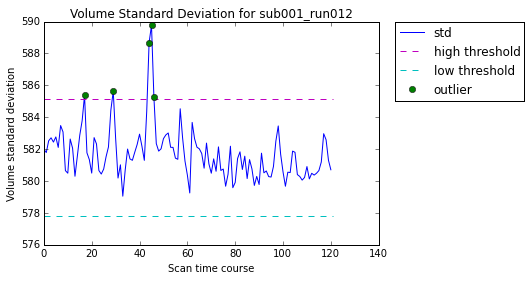

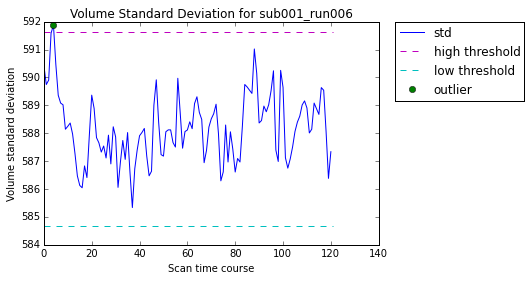

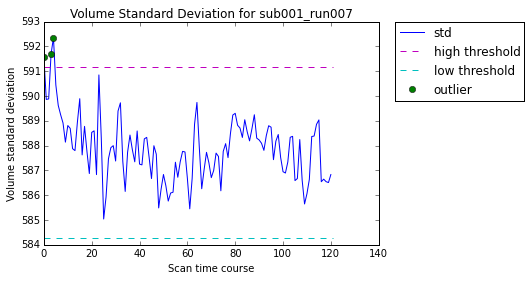

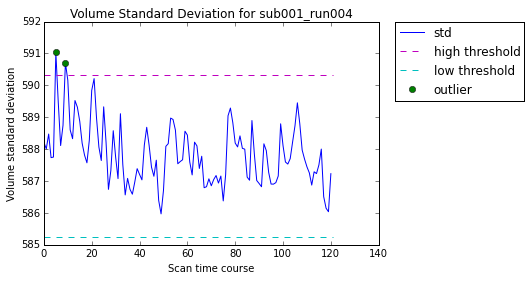

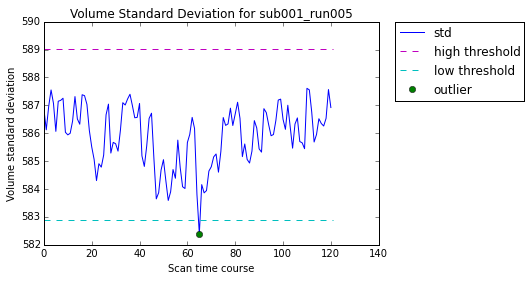

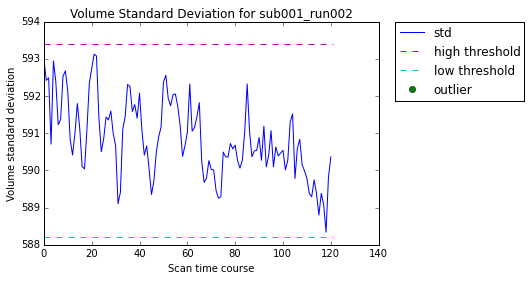

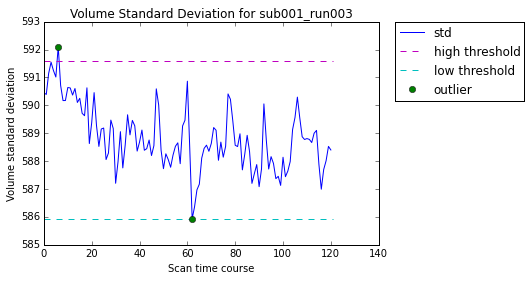

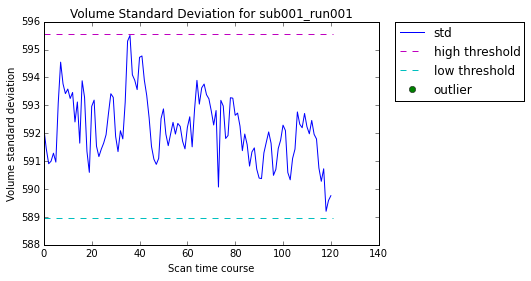

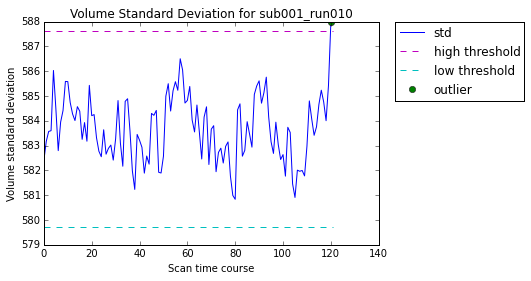

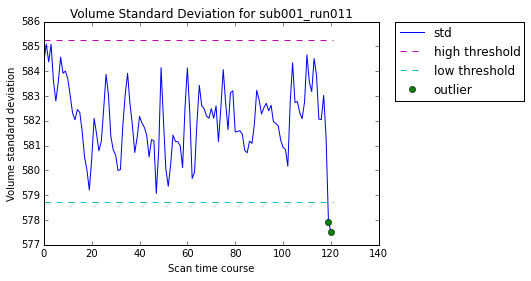

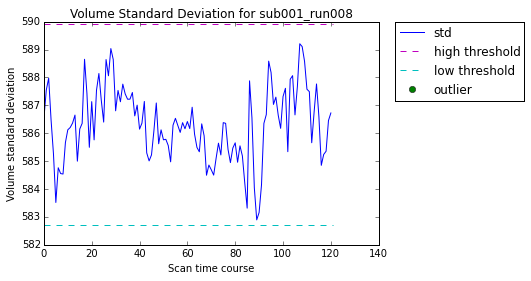

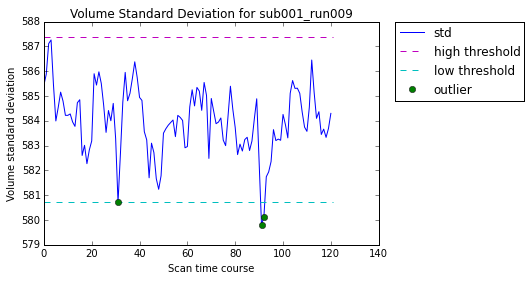

In [7]:
# use v_std to check outliers for all 12 runs for subject 001

for key, imgresult in img.iteritems():
    data = imgresult.get_data()
    v_std = vol_std(data)
    outlier_indices, thresh = iqr_outliers(v_std)
    y_value = [v_std[i] for i in outlier_indices]
    plt.figure()
    plt.plot(v_std, label = 'std')
    plt.plot([0,len(v_std)],[thresh[1],thresh[1]], "k--",\
    label = 'high threshold', color='m')
    plt.plot([0,len(v_std)],[thresh[0],thresh[0]], "k--",\
    label = 'low threshold', color='c')
    plt.plot(outlier_indices, y_value, 'o', color = 'g', label = 'outlier')
    plt.xlabel('Scan time course')
    plt.ylabel('Volume standard deviation')
    plt.title('Volume Standard Deviation for %s'%key)
    plt.subplot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., numpoints = 1) 

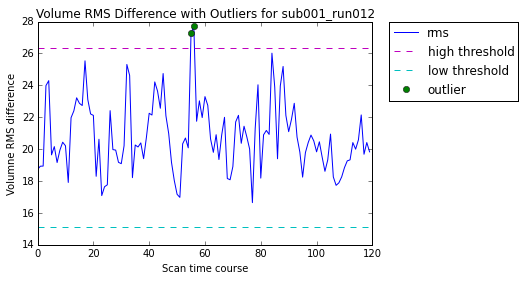

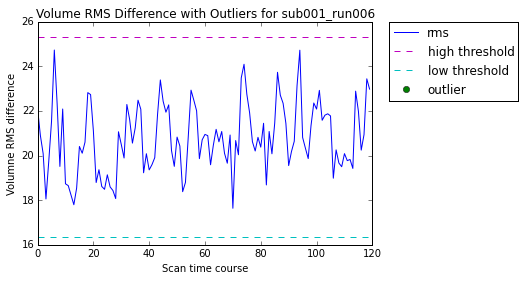

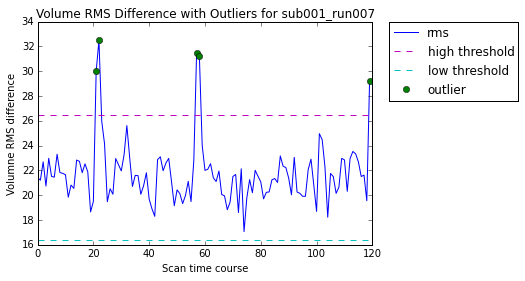

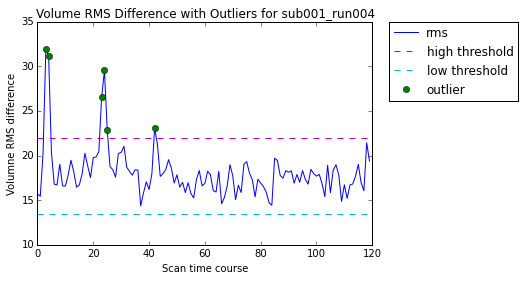

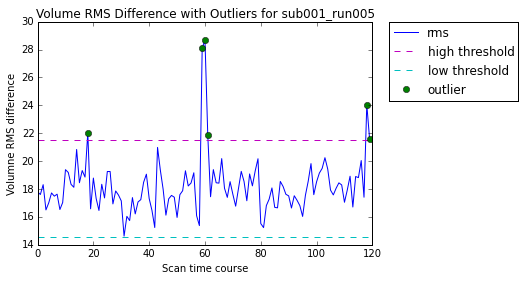

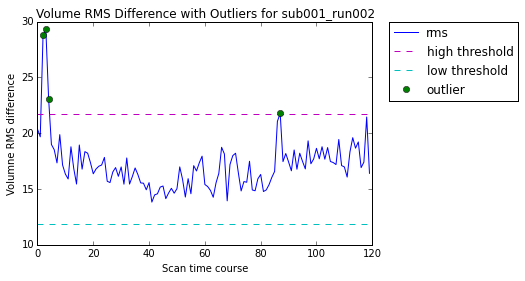

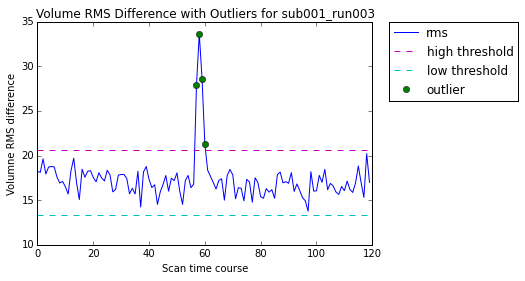

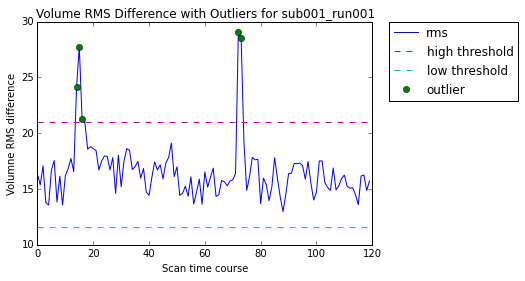

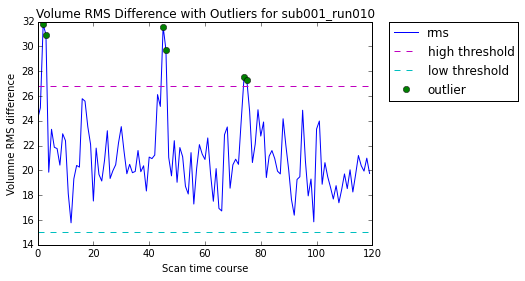

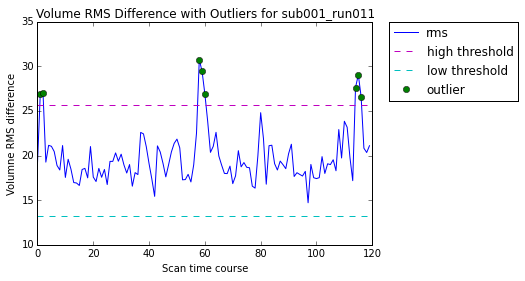

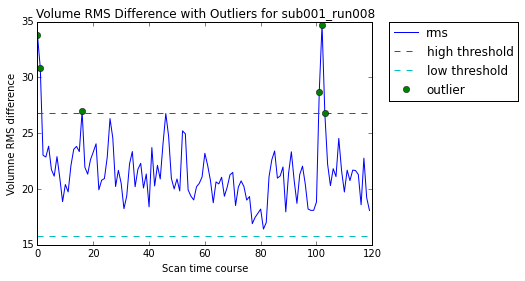

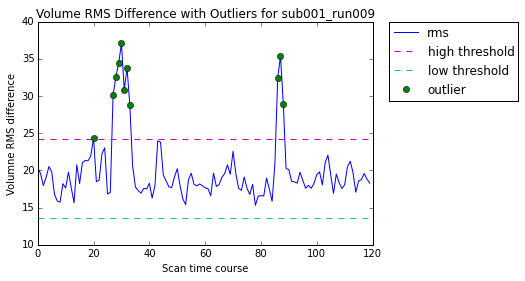

In [8]:
# use rms_diff to check outlier for all 12 runs for subject 1
for key, imgresult in img.iteritems():
    data = imgresult.get_data()
    rms_diff = vol_rms_diff(data)
    rms_outlier_indices, rms_thresh = iqr_outliers(rms_diff)
    y_value2 = [rms_diff[i] for i in rms_outlier_indices]
    
    plt.figure()
    plt.plot(rms_diff, label = 'rms')
    plt.plot([0,len(rms_diff)],[rms_thresh[1],rms_thresh[1]], "k--",\
    label = 'high threshold', color='m')
    plt.plot([0,len(rms_diff)],[rms_thresh[0],rms_thresh[0]], "k--",\
    label = 'low threshold', color='c')
    plt.plot(rms_outlier_indices, y_value2, 'o', color = 'g', label = 'outlier')
    plt.xlabel('Scan time course')
    plt.ylabel('Volumne RMS difference')
    plt.title('Volume RMS Difference with Outliers for %s' % key)
    plt.subplot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., numpoints = 1) 


In [9]:
# remove outliers from the data by using rms_diff and extend indices
clean_data = {}
outlier_index = {}
for key, imgresult in img.iteritems():
    clean_data[key] = imgresult.get_data()
    rms_diff = vol_rms_diff(clean_data[key])
    rms_outlier_indices, rms_thresh = iqr_outliers(rms_diff)
    rms_extend_indices = extend_diff_outliers(rms_outlier_indices)
    outlier_index[key] = rms_extend_indices
    clean_data[key] = np.delete(clean_data[key], rms_extend_indices, axis = 3)

In [10]:
# check if the shape changed
clean_data["sub001_run009"].shape

(40, 64, 64, 107)

In [11]:
# get general all tr times == 121*2.5 = about 300 s
# this is the x-axis to plot hemodynamic prediction
all_tr_times = np.arange(sub1.BOLD_shape[-1]) * sub1.TR

In [12]:
# %load get_object_neural.py

def get_object_neural(sub_ID, condition_dict, TR, n_vox, object_name="all", check=0):
    """
    get object neural array for specific object from all runs, odd runs or even runs
    
    parameters
    ----------
    condition_dict: dictionary of all condition files
    object_name: desired object name: 'house','scrambledpix','cat','shoe','bottle','scissors','chair','face'
    TR: TR for fMRI
    n_vox: time course of fMRI
    check: 1= odd runs, 2=even runs, others = all runs
    
    output
    -------
    a dictionary of run name : (neural array, path of the bold image) for that run
    ex:
    
    {
    'run001-bottle-neural': (array([ 0.,  0.,  0.,  0.,  0., ...]), bold path)
    'run002-bottle-neural': (array([ 0.,  0.,  0.,  0.,  0., ...]), bold path)
    }
    
    
    """

    # check if the object is valid
    valid_object = ["house", "scrambledpix", "cat", "shoe", "bottle", "scissors", "chair", "face", "all"]
    assert (object_name in valid_object)


    condition_dict_key = condition_dict.keys()
    result = {}

    # to get ALL
    if object_name == "all":
        for i in condition_dict_key:
            result[i] = (events2neural(condition_dict[i], TR, n_vox), "../data/ds105/%s/BOLD/task001_"% sub_ID + i[:6]+"/bold.nii.gz")

    else:
        for i in condition_dict_key:
            if check == 1:
                if object_name in i:
                    if int(i[3:6])%2 ==1:
                        result[i] = (events2neural(condition_dict[i], TR, n_vox), "../data/ds105/%s/BOLD/task001_"% sub_ID + i[:6]+"/bold.nii.gz")
            elif check == 2:
                if object_name in i:
                    if int(i[3:6])%2 ==0:
                        result[i] = (events2neural(condition_dict[i], TR, n_vox), "../data/ds105/%s/BOLD/task001_"% sub_ID + i[:6]+"/bold.nii.gz")
            else:
                if object_name in i:
                    result[i] = (events2neural(condition_dict[i], TR, n_vox), "../data/ds105/%s/BOLD/task001_"%sub_ID + i[:6]+"/bold.nii.gz")

    return result



In [13]:
all_tr_times

array([   0. ,    2.5,    5. ,    7.5,   10. ,   12.5,   15. ,   17.5,
         20. ,   22.5,   25. ,   27.5,   30. ,   32.5,   35. ,   37.5,
         40. ,   42.5,   45. ,   47.5,   50. ,   52.5,   55. ,   57.5,
         60. ,   62.5,   65. ,   67.5,   70. ,   72.5,   75. ,   77.5,
         80. ,   82.5,   85. ,   87.5,   90. ,   92.5,   95. ,   97.5,
        100. ,  102.5,  105. ,  107.5,  110. ,  112.5,  115. ,  117.5,
        120. ,  122.5,  125. ,  127.5,  130. ,  132.5,  135. ,  137.5,
        140. ,  142.5,  145. ,  147.5,  150. ,  152.5,  155. ,  157.5,
        160. ,  162.5,  165. ,  167.5,  170. ,  172.5,  175. ,  177.5,
        180. ,  182.5,  185. ,  187.5,  190. ,  192.5,  195. ,  197.5,
        200. ,  202.5,  205. ,  207.5,  210. ,  212.5,  215. ,  217.5,
        220. ,  222.5,  225. ,  227.5,  230. ,  232.5,  235. ,  237.5,
        240. ,  242.5,  245. ,  247.5,  250. ,  252.5,  255. ,  257.5,
        260. ,  262.5,  265. ,  267.5,  270. ,  272.5,  275. ,  277.5,
      

In [14]:
# %load stimuli.py
""" Functions to work with standard OpenFMRI stimulus files

The functions have docstrings according to the numpy docstring standard - see:

    https://github.com/numpy/numpy/blob/master/doc/HOWTO_DOCUMENT.rst.txt
"""

import numpy as np

def events2neural(task_fname, tr, n_trs):
    """ Return predicted neural time course from event file `task_fname`

    Parameters
    ----------
    task_fname : str
        Filename of event file
    tr : float
        TR in seconds
    n_trs : int
        Number of TRs in functional run

    Returns
    -------
    time_course : array shape (n_trs,)
        Predicted neural time course, one value per TR
    """
    task = np.loadtxt(task_fname)
    # Check that the file is plausibly a task file
    if task.ndim != 2 or task.shape[1] != 3:
        raise ValueError("Is {0} really a task file?", task_fname)
    # Convert onset, duration seconds to TRs
    task[:, :2] = task[:, :2] / tr
    # Neural time course from onset, duration, amplitude for each event
    time_course = np.zeros(n_trs)
    for onset, duration, amplitude in task:
        time_course[onset:onset + duration] = amplitude
    return time_course


In [15]:
# the y-axis to plot hemodynamic prediction is the neural value from condition
sub1_neural = get_object_neural(sub1.sub_id ,sub1.conditions, sub1.TR, sub1.BOLD_shape[-1])

In [16]:
sub1_neural.keys()

['run003-house',
 'run008-bottle',
 'run010-shoe',
 'run008-scrambledpix',
 'run011-face',
 'run007-scrambledpix',
 'run012-shoe',
 'run010-house',
 'run011-scissors',
 'run006-house',
 'run007-face',
 'run011-shoe',
 'run004-cat',
 'run010-scissors',
 'run001-chair',
 'run011-cat',
 'run009-bottle',
 'run008-scissors',
 'run004-scrambledpix',
 'run001-bottle',
 'run008-chair',
 'run011-house',
 'run001-house',
 'run003-face',
 'run009-chair',
 'run002-scissors',
 'run004-house',
 'run003-scrambledpix',
 'run011-chair',
 'run012-cat',
 'run001-scissors',
 'run010-cat',
 'run002-scrambledpix',
 'run002-face',
 'run009-house',
 'run004-chair',
 'run007-bottle',
 'run012-bottle',
 'run005-scissors',
 'run012-scrambledpix',
 'run008-face',
 'run006-bottle',
 'run006-scissors',
 'run009-scissors',
 'run002-bottle',
 'run005-house',
 'run002-house',
 'run003-chair',
 'run011-scrambledpix',
 'run009-shoe',
 'run009-cat',
 'run006-cat',
 'run010-bottle',
 'run012-scissors',
 'run011-bottle',
 

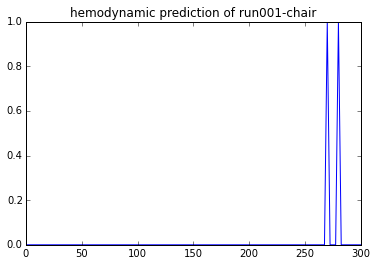

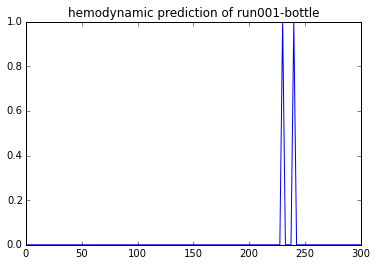

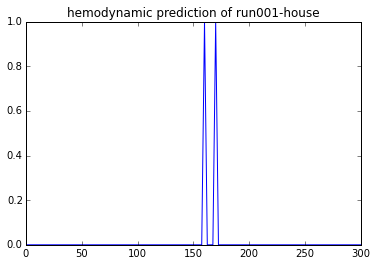

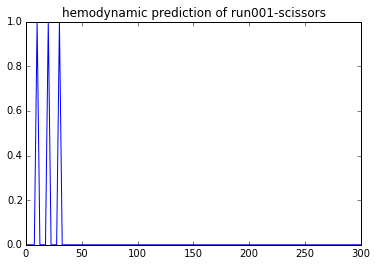

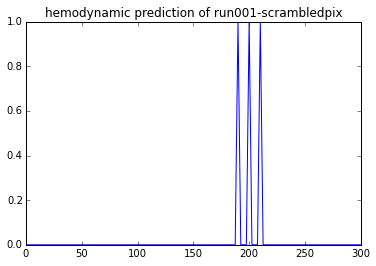

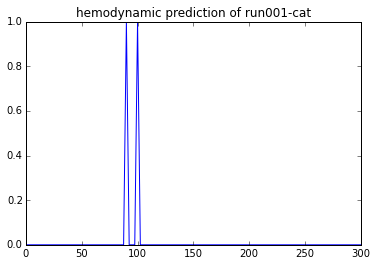

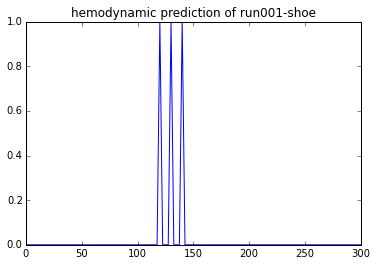

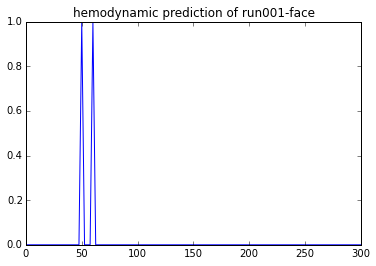

In [17]:
# show each hemodynamic prediction for run001
for i in sub1_neural.keys():
    if "run001" in i:
        plt.figure()
        plt.plot(all_tr_times, sub1_neural[i][0])
        plt.title("hemodynamic prediction of %s" % i )

In [18]:
# %load convulsion.py
"""trying to develop a function to get the convulsion of the time course"""
# noinspection PyUnresolvedReferences

import scipy.stats
from scipy.stats import gamma
import numpy as np

# hrf function from lecture
def hrf(tr_times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(tr_times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(tr_times, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6


# convolsion and deal with overflow
def convolsion(neural, hrf_at_trs):
    convolved = np.convolve(neural, hrf_at_trs)
    convolved = convolved[:-(len(hrf_at_trs)-1)]
    return convolved

# get all convolsion result and save in a dictionary
def get_all_convolved (dictionary_of_all_neural):
    result = {}
    for i in dictionary_of_all_neural.keys():
        convolved = convolsion(sub1_neural[i][0], hrf_at_trs)
        result[i] = convolved
    return result

# remove outlier in convolsion results
def remove_outlier (subid ,convolsion_data_dict, outlier_directory, axis=0):
    """
    Parameters
    ----------
    subid = subject ID
    convolsion_data_dict: the convolsion dictionary
    outlier_directory: outlier dictionary
    axis: in this case, axis=0

    Returns
    -------
    dictionary of convolsion result without outlier
    """
    result = {}
    for i in convolsion_data_dict.keys():
        result[i] = np.delete(convolsion_data_dict[i], outlier_directory[subid + '_' + i[:6]], axis)
    return result

In [19]:
# assume true HRF starts at zero, and gets to zero sometime before 35 seconds.
tr_times = np.arange(0, 30, sub1.TR)
hrf_at_trs = hrf(tr_times)

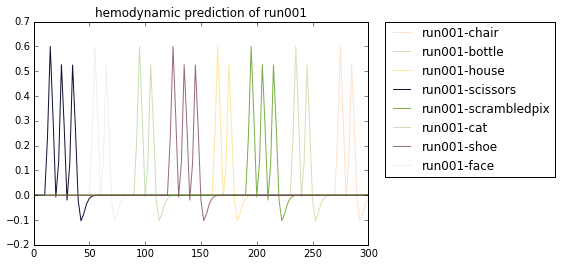

In [20]:
# get convolsion data for each objects in this run -> show figure for run001
for i in sub1_neural.keys():
    if "run001" in i:
        convolved = convolsion(sub1_neural[i][0], hrf_at_trs)
        plt.plot(all_tr_times, convolved, c=np.random.rand(4), label = "%s" % i)
plt.title("hemodynamic prediction of run001")
plt.subplot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
    

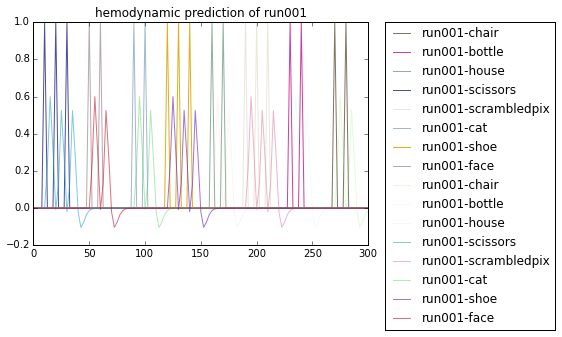

In [21]:
# show relationship between stimulation time and bold signals
# plot the stimulation:
for i in sub1_neural.keys():
    if "run001" in i:
        plt.plot(all_tr_times, sub1_neural[i][0], c=np.random.rand(4), label = "%s" % i)

# plot the convolsion/bold signal
for i in sub1_neural.keys():
    if "run001" in i:
        convolved = convolsion(sub1_neural[i][0], hrf_at_trs)
        plt.plot(all_tr_times, convolved, c=np.random.rand(4), label = "%s" % i)
plt.title("hemodynamic prediction of run001")
plt.subplot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 

In [22]:
# get convolsion data for all objects in all runs -> save as files
for i in sub1_neural.keys():
    convolved = convolsion(sub1_neural[i][0], hrf_at_trs)
    np.savetxt("%s_%s-convolved.txt"%(sub1.sub_id, i), convolved)

In [23]:
# continue analysis -> so, here we save all convolved results in a dictionary
# %load convulsion.py
"""trying to develop a function to get the convulsion of the time course"""
# noinspection PyUnresolvedReferences

import scipy.stats
from scipy.stats import gamma
import numpy as np

# hrf function from lecture
def hrf(tr_times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(tr_times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(tr_times, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6


# convolsion and deal with overflow
def convolsion(neural, hrf_at_trs):
    convolved = np.convolve(neural, hrf_at_trs)
    convolved = convolved[:-(len(hrf_at_trs)-1)]
    return convolved

# get all convolsion result and save in a dictionary
def get_all_convolved (dictionary_of_all_neural):
    result = {}
    for i in dictionary_of_all_neural.keys():
        convolved = convolsion(sub1_neural[i][0], hrf_at_trs)
        result[i] = convolved
    return result

# remove outlier in convolsion results
def remove_outlier (subid ,convolsion_data_dict, outlier_directory, axis=0):
    """
    Parameters
    ----------
    subid = subject ID
    convolsion_data_dict: the convolsion dictionary
    outlier_directory: outlier dictionary
    axis: in this case, axis=0

    Returns
    -------
    dictionary of convolsion result without outlier
    """
    result = {}
    for i in convolsion_data_dict.keys():
        result[i] = np.delete(convolsion_data_dict[i], outlier_directory[subid + '_' + i[:6]], axis)
    return result

In [24]:
sub1_convolved = get_all_convolved(sub1_neural)

In [25]:
# since we remove outlier in the data -> we also need to remove the relavent time point in convlved results:
# remind: outlier index:
outlier_index.keys()

['sub001_run001',
 'sub001_run006',
 'sub001_run007',
 'sub001_run004',
 'sub001_run005',
 'sub001_run002',
 'sub001_run003',
 'sub001_run012',
 'sub001_run011',
 'sub001_run009',
 'sub001_run008',
 'sub001_run010']

In [26]:
# remind: sub1_convolved:
sub1_convolved.keys()

['run003-house',
 'run008-bottle',
 'run010-shoe',
 'run008-scrambledpix',
 'run011-face',
 'run007-scrambledpix',
 'run012-shoe',
 'run010-house',
 'run011-scissors',
 'run006-house',
 'run007-face',
 'run011-shoe',
 'run004-cat',
 'run010-scissors',
 'run001-chair',
 'run011-cat',
 'run009-bottle',
 'run008-scissors',
 'run004-scrambledpix',
 'run001-bottle',
 'run008-chair',
 'run011-house',
 'run001-house',
 'run003-face',
 'run009-chair',
 'run002-scissors',
 'run004-house',
 'run003-scrambledpix',
 'run011-chair',
 'run012-cat',
 'run001-scissors',
 'run010-cat',
 'run002-scrambledpix',
 'run002-face',
 'run009-house',
 'run004-chair',
 'run007-bottle',
 'run012-bottle',
 'run005-scissors',
 'run012-scrambledpix',
 'run008-face',
 'run006-bottle',
 'run006-scissors',
 'run005-shoe',
 'run002-bottle',
 'run005-house',
 'run002-house',
 'run003-chair',
 'run011-scrambledpix',
 'run009-shoe',
 'run009-cat',
 'run006-cat',
 'run010-bottle',
 'run012-scissors',
 'run011-bottle',
 'run

In [27]:
# before removing outlier, we have all 121 time points
sub1_convolved["run001-bottle"].shape

(121,)

In [28]:
# remove outlier
sub1_convolved = remove_outlier(sub1.sub_id, sub1_convolved, outlier_index)

In [29]:
# now the time course should be the same as the clean data
print (clean_data["sub001_run001"].shape[-1])
print (sub1_convolved["run001-bottle"].shape)

114
(114,)


In [30]:
# Focus on this run1 to apply linear regression
# flatten the data
data_run1_2d = np.reshape(clean_data['sub001_run001'],(-1,clean_data['sub001_run001'].shape[-1]))

In [31]:
data_run1_2d.shape

(163840, 114)

In [32]:
# create design matrix
# in this order: bottle, cat, chair, face, house, scissors, scrambledpix, shoe, average of all signal, ones

object_list = ["bottle", "cat", "chair", "face", "house", "scissors", "scrambledpix", "shoe"]
design_matrix_run1 = np.ones((clean_data["sub001_run001"].shape[-1],(len(object_list)+2)))
for i in xrange(design_matrix_run1.shape[-1]-2):
    design_matrix_run1[:,i] = sub1_convolved["run001-" + object_list[i]]
design_matrix_run1[:,-2] = np.mean(data_run1_2d, axis=0)

In [33]:
# from lecture
def scale_design_mtx(X):
    """utility to scale the design matrix for display
    This scales the columns to their own range so we can see the variations
    across the column for all the columns, regardless of the scaling of the
    column.
    """
    mi, ma = X.min(axis=0), X.max(axis=0)
     
    # Vector that is True for columns where values are not
    # all almost equal to each other
    col_neq = (ma - mi) > 1.e-8
    Xs = np.ones_like(X)
    # Leave columns with same value throughout with 1s
    # Scale other columns to min, max in column
    mi = mi[col_neq]
    ma = ma[col_neq]
    Xs[:,col_neq] = (X[:,col_neq] - mi)/(ma - mi)
    return Xs

In [34]:
Xs1 = scale_design_mtx(design_matrix_run1)

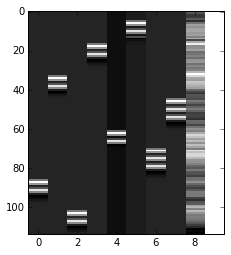

In [35]:
# show sacled design matrix
plt.imshow(Xs1, aspect=0.1, interpolation= "nearest", cmap="gray")

In [36]:
# use the function from lecture to run linear regression and using contrast
import numpy.linalg as npl
from scipy.stats import t as t_dist

def t_stat(y, X, c):
    """ betas, t statistic and significance test given data, design matrix, contrast
    This is OLS estimation; we assume the errors to have independent
    and identical normal distributions around zero for each $i$ in
    $\e_i$ (i.i.d).
    """
    # Make sure y, X, c are all arrays
    #y = np.asarray(y)
    #X = np.asarray(X)
    #c = c.T
    c = np.atleast_2d(c).T # As column vector
    # Calculate the parameters - b hat
    beta = npl.pinv(X).dot(y)
    # The fitted values - y hat
    fitted = X.dot(beta)
    # Residual error
    errors = y - fitted
    # Residual sum of squares
    RSS = (errors**2).sum(axis=0)
    # Degrees of freedom is the number of observations n minus the number
    # of independent regressors we have used.  If all the regressor
    # columns in X are independent then the (matrix rank of X) == p
    # (where p the number of columns in X). If there is one column that
    # can be expressed as a linear sum of the other columns then
    # (matrix rank of X) will be p - 1 - and so on.
    df = X.shape[0] - npl.matrix_rank(X)
    # Mean residual sum of squares
    MRSS = RSS / df
    # calculate bottom half of t statistic
    #SE = np.sqrt(MRSS * c.T.dot(npl.pinv(X.T.dot(X)).dot(c)))
    SE = np.sqrt(MRSS * c.T.dot(npl.pinv(X.T.dot(X)).dot(c)))
    t = c.T.dot(beta) / SE
    # Get p value for t value using cumulative density dunction
    # (CDF) of t distribution
    ltp = t_dist.cdf(t, df) # lower tail p
    p = 1 - ltp # upper tail p
    
    return beta, t, df, p

In [37]:
# regressors: "bottle", "cat", "chair", "face", "house", "scissors", "scrambledpix", "shoe", "average", one
# first study if there is any spots that is lighted up under 'face' stimulation
B_face, t_face, df_face, p_face = t_stat(data_run1_2d.T, Xs1, np.array([0,0,0,1,0,0,0,0,-1,0]))

/Users/tzuchieh/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: RuntimeWarning: invalid value encountered in true_divide
/Users/tzuchieh/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1647: RuntimeWarning: invalid value encountered in greater
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
/Users/tzuchieh/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1647: RuntimeWarning: invalid value encountered in less
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
/Users/tzuchieh/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1648: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


In [38]:
# see warnings! before there are some NaN in the array (there is number/0 in the  calculation!!)
# Not sure what to do-> here I change NaN to 0
t_face[np.isnan(t_face)] = 0

/Users/tzuchieh/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


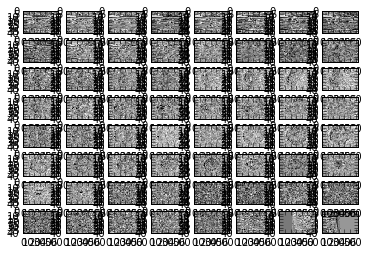

In [39]:
# show t plot
t_face_3d = np.reshape(t_face, (40,64,64))
plt.figure()
for i in xrange(64):
    plt.subplot(8,8,i)
    plt.imshow(t_face_3d[:,:,i], interpolation="nearest", cmap="gray")

In [40]:
# doesn't show specific brain pattern.... -> use mask?
# create mask, set threshold = 500
mean_by_time = np.mean(clean_data["sub001_run001"], axis=3)
mask = np.zeros_like(mean_by_time)
for i in xrange(64):
    mask[:,:,i] = mean_by_time[:,:,i] > 500

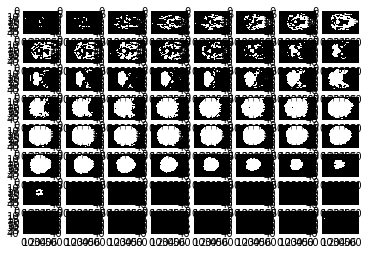

In [41]:
# show mask:
for i in xrange(64):
    plt.subplot(8,8,i)
    plt.imshow(mask[:,:,i], interpolation="nearest", cmap="gray")

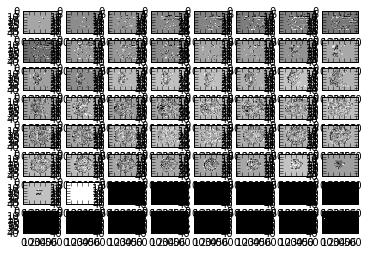

In [42]:
# mask t-plot
t_face_3d[mask==0] =0
for i in xrange(64):
    plt.subplot(8,8,i)
    plt.imshow(t_face_3d[:,:,i], interpolation="nearest", cmap="gray")

In [43]:
# ??? don't see specific pattern? @@

/Users/tzuchieh/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: RuntimeWarning: invalid value encountered in true_divide


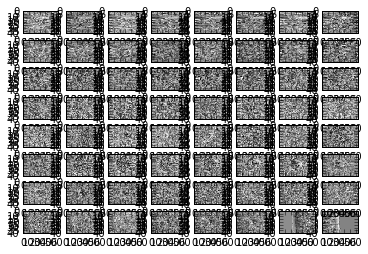

In [44]:
# try analyzing house in run001 
B_house, t_house, df_house, p_house = t_stat(data_run1_2d.T, Xs1, np.array([0,0,0,0,1,0,0,0,-1,0]))
t_house[np.isnan(t_house)] = 0
t_house_3d = np.reshape(t_house, (40,64,64))
for i in xrange(64):
    plt.subplot(8,8,i)
    plt.imshow(t_house_3d[:,:,i], interpolation="nearest", cmap="gray")

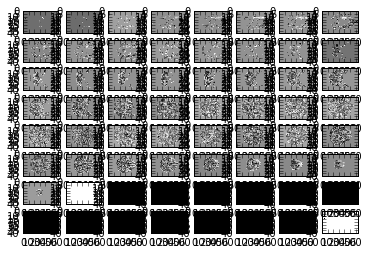

In [45]:
#apply mask for house t plot
t_house_3d[mask==0] =0
for i in xrange(64):
    plt.subplot(8,8,i)
    plt.imshow(t_house_3d[:,:,i], interpolation="nearest", cmap="gray")

In [46]:
# compare between these face and house run
run1_face_house = np.corrcoef(t_face_3d.ravel(), t_house_3d.ravel())
run1_face_house

array([[ 1.        ,  0.15980369],
       [ 0.15980369,  1.        ]])